### Class Definition

In [1]:
import torch
import torch.nn as nn


class HeatEquationNN(nn.Module):
    def __init__(self, layers):
        super(HeatEquationNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
    
    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = torch.tanh(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# example usage:
# model = HeatEquationNN(layers=[2, 10, 10, 1]) 
# Input Layer (2 neurons for x and t) -> 2 Hidden Layers (10 neurons each) -> Output Layer (1 neuron for u)

/Users/oliverstalker/Downloads/dev/PINN/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:20: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:84.)
  device: torch.device = torch.device(torch._C._get_default_device()),  # torch.device('cpu'),


### Loss Function

In [9]:
def physics_loss(model, x, t, alpha):
    # Ensure x and t require gradients
    x.requires_grad = True
    t.requires_grad = True
    
    u = model(torch.cat([x, t], dim=1))
    
    # Compute u_t
    u_t = torch.autograd.grad(
        outputs=u,
        inputs=t,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # Compute u_x
    u_x = torch.autograd.grad(
        outputs=u,
        inputs=x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # Compute u_xx
    u_xx = torch.autograd.grad(
        outputs=u_x,
        inputs=x,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # Physics residual
    physics_residual = u_t - alpha * u_xx
    return torch.mean(physics_residual**2)


### Supplemental Data Generation

In [10]:
import numpy as np

alpha = 0.01    # thermal diffusivity
L = 1.0         # length of the rod
T = 1.0        # total time
dx = 0.01      # spatial resolution (step size)
dt = 0.0001   # temporal resolution

# Discretized space and time
x = np.arange(0, L + dx, dx)
t = np.arange(0, T + dt, dt)

# initial conditions sin(pi * x)
u_initial = np.sin(np.pi * x)

# Boundary Conditions: u(0, t) = u(L, t) = 0
u = np.zeros((len(t), len(x)))
u[0, :] = u_initial

# Finite Differences method to solve the heat equation
for i in range(1, len(t)):
    for j in range(1, len(x) - 1):
        u[i, j] = u[i-1, j] + alpha * dt / dx**2 * (u[i-1, j+1] - 2 * u[i-1, j] + u[i-1, j-1])

# Training data
X, T = np.meshgrid(x, t)
X = X.flatten()[:, None]
T = T.flatten()[:, None]
U = u.flatten()[:, None]

# convert to tensors
x_data = torch.tensor(X, dtype=torch.float32, requires_grad=True)
t_data = torch.tensor(T, dtype=torch.float32, requires_grad=True)
u_data = torch.tensor(U, dtype=torch.float32)

# Example of the data shapes
print(f'x_data shape: {x_data.shape}')
print(f't_data shape: {t_data.shape}')
print(f'u_data shape: {u_data.shape}')

x_data shape: torch.Size([1010101, 1])
t_data shape: torch.Size([1010101, 1])
u_data shape: torch.Size([1010101, 1])


### Training Loop

In [20]:
import torch.optim as optim
import matplotlib.pyplot as plt
model = HeatEquationNN(layers=[2, 20, 20, 20, 1])
optimizer = optim.Adam(model.parameters(), lr=0.01)
alpha = 0.01 # diffusion coefficient

def plot_training_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Training Losses over Epochs")
    plt.legend()
    plt.show()

losses = []
for epoch in range(10):
    optimizer.zero_grad()
    
    # prediction
    u_pred = model(torch.cat([x_data, t_data], dim=1))

    # Data loss
    data_loss = torch.mean((u_data - u_pred)**2)

    # Physics loss
    physics_loss_val = physics_loss(model, x_data, t_data, alpha)

    # Total loss
    loss = data_loss + physics_loss_val
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

    if epoch % 1 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.3285936117172241
Epoch 1, Loss: 0.14465053379535675
Epoch 2, Loss: 0.08950342983007431
Epoch 3, Loss: 0.120226189494133
Epoch 4, Loss: 0.13588453829288483
Epoch 5, Loss: 0.11892596632242203
Epoch 6, Loss: 0.09903435409069061
Epoch 7, Loss: 0.09226763248443604
Epoch 8, Loss: 0.09703797847032547
Epoch 9, Loss: 0.10409684479236603


### Evaluation

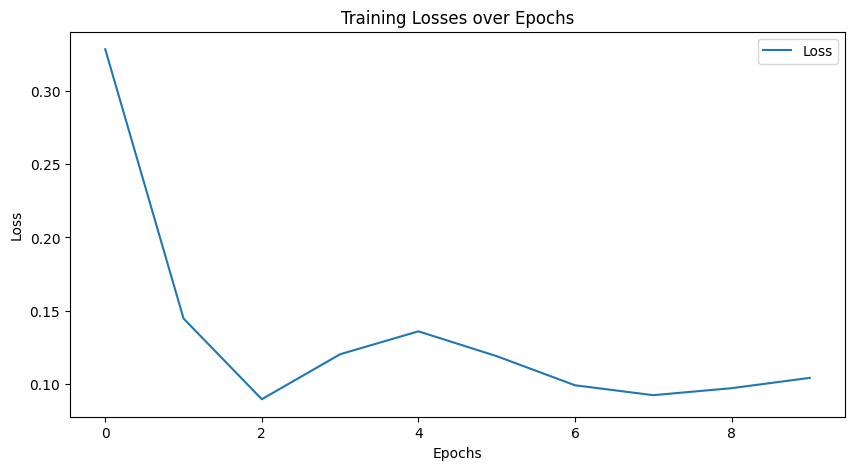

In [21]:
plot_training_losses(losses)